# Exercise 1: Clustering, Bisecting k-Means

In [52]:
import numpy as np
from sklearn.cluster import k_means

def bkmeans(X:np.ndarray, k:int, i:int) -> np.ndarray:
    """Bisecting k-Means.
    
    Parameters
    ----------
    X : ndarray
        The matrix to perform Bisecting k-Means on.
    k : int
        The number of clusters to split the data into.
    i : int
        The number of iterations to perform the k-Means with different centroids.
    """
    res = np.zeros(X.shape[0], dtype=int)
    for kk in range(1, k):
        values, counts = np.unique(res, return_counts=True)
        most_common_k = values[counts.argmax()]
        most_common_indices = res == most_common_k
        new_clusters = k_means(X[most_common_indices], 2, n_init=i)[1]
        res[most_common_indices] = np.where(new_clusters == 0, most_common_k, kk)
    return res

# Testing bisecting k-Means

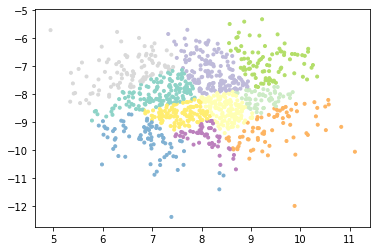

In [53]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=1, n_features=2)
k = 10
c = bkmeans(X, k, 100)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=c, cmap="Set3", marker=".")
plt.show()

# Exercise 2: Sammon Mapping
I had some problem in the beginning with implementing an efficient Sammon Mapping. At first I made it using three for loops. One for the number of iterations, one for _i_ (number of samples) and one for _j_ (also number of samples). It worked fine but was extremely slow, 1000 samples and 100 iterations equals 100 000 000 iterations, which is not so fast...

My goal now was to remove one of the for loops for the rows, that would result in only 100 000 iterations for the same dataset. With some reshaping and fiddling with the axis, removing one loop in favor of vector matrix operations. Maybe not the prettiest, but the speed gain is amazing. Previously, the code cell for exercise **3.1** took about 20 minutes to run, with max iterations of 50. With the new improved Sammon Mapping it was run in 51 seconds with max iterations set at 200.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

def sammons_stress(X, Y):
    """Calculate Sammon's Stress.
    
    Parameters
    ----------
    X : ndarray
        The input matrix.
    Y : ndarray
        The output matrix.
    """
    S = np.triu(X)
    d = np.triu(Y)
    return (1 / np.sum(S)) * np.sum(np.divide(np.square(d - S), S, out=np.zeros_like(S), where=S!=0))

def sammon(X, max_iter=100, epsilon=0.01, alpha=0.3, init="random", verbose=False):
    """Perform Sammon Mapping on X.
    
    Parameters
    ----------
    X : ndarray
        The matrix to reduce the dimensions of.
    max_iter : int
        The maximum number of iterations to perform.
    epsilon : float
        The error threshold, break if Sammon's Stress is lower.
    alpha : float
        The learning rate.
    init : str
        The method to init the resulting matrix with, use "random" for random blobs, else PCA will be used.
    verbose : boolean
        Use True to print iteration and Sammon's Stress.
    """
    if init == "random":
        Y = make_blobs(n_samples=X.shape[0], n_features=2, centers=1, random_state=1337)[0]
    else:
        Y = PCA(n_components=2).fit_transform(X)

    S = pairwise_distances(X)
    S = np.where(S==0, 1e-150, S)

    c = np.sum(np.triu(S))
    l = S.shape[0]

    for t in range(max_iter):
        d = pairwise_distances(Y)
        d = np.where(d==0, 1e-150, d)

        E = sammons_stress(S, d)
        if verbose:
            print(f"Iter: {t}, E = {E}")
        if E < epsilon:
            print(f"Error threshold of {epsilon}, reached at iter {t}. E = {E}")
            break

        first_1_1d  = ((S-d)/(d*S)).reshape(l*l)
        second_1_1d, second_2_1d = (1/(S*d)).reshape(l*l), (S-d).reshape(l*l)
        second_3_1d, second_4_1d = d.reshape(l*l), (1 + ((S-d)/d)).reshape(l*l)
        for i in range(Y.shape[0]):
            start, end = i*l, (i*l)+l

            first_f1 = first_1_1d[start:end]
            first = (-2/c)*np.sum(np.c_[first_f1, first_f1] * (Y[i] - Y), axis=0)
            
            second_1, second_2 = second_1_1d[start:end], second_2_1d[start:end]
            second_3, second_4 = second_3_1d[start:end], second_4_1d[start:end]
            second = (-2/c)*np.sum(np.c_[second_1, second_1] * (np.c_[second_2, second_2] - ((np.square(Y[i] - Y)/second_3[:, None]) * second_4[:, None])), axis=0)

            Y[i] = Y[i] - (alpha * (first/np.abs(second)))
    return Y

# First test of Sammon Mapping
Here's a first test of Sammon Mapping on a S-curve. Fiddling with the alpha yields some pretty good results.

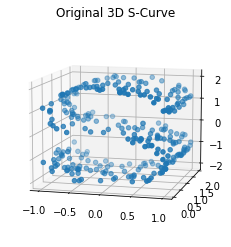

Iter: 0, E = 0.6390167608805878
Iter: 1, E = 0.5175148005749113
Iter: 2, E = 0.40612169133714593
Iter: 3, E = 0.3984854560220881
Iter: 4, E = 0.8242515864190099
Iter: 5, E = 0.815392495840205
Iter: 6, E = 0.3934202564914064
Iter: 7, E = 0.6581460336508639
Iter: 8, E = 2.2875512414144494
Iter: 9, E = 37.61581145892169
Iter: 10, E = 0.13924886420471572
Iter: 11, E = 0.2836469047713173
Iter: 12, E = 0.06175176264341181
Iter: 13, E = 0.03711349529307709
Iter: 14, E = 0.12943485602174357
Iter: 15, E = 0.03167975170605403
Iter: 16, E = 0.027404909329568267
Iter: 17, E = 0.030302637600516692
Iter: 18, E = 0.024473008415141703
Iter: 19, E = 0.023656812164454005
Iter: 20, E = 0.024411275157692276
Iter: 21, E = 0.023264267138415878
Iter: 22, E = 0.022975026269898155
Error threshold of 0.023, reached at iter 22. E = 0.022975026269898155


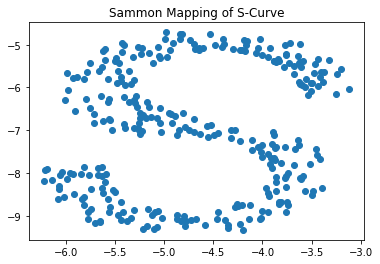

In [55]:
from sklearn.datasets import make_s_curve

X, y = make_s_curve(300, random_state=1)

fig = plt.figure("Original 3D S-Curve")
ax = fig.add_subplot(projection="3d")
ax.title.set_text("Original 3D S-Curve")
ax.view_init(10, 285)
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

Y = sammon(X, max_iter=200, epsilon=0.023, alpha=1.0, verbose=True)
plt.figure("Sammon Mapping of S-Curve")
plt.title("Sammon Mapping of S-Curve")
plt.scatter(Y[:,0], Y[:,1])

plt.show()

# Exercise 3.1
Here is the code cell that previously took 20 minutes to run, but now takes 51 seconds. So, you don't have to be afraid to re-run this.

The three datasets I chose:
1. Vehicle silhouettes - 18 features, 4 labels/classes
2. Diabetes - 8 features, 2 labels/classes
3. Vowels - 10 features, 11 labels/classes

Iter: 0, E = 0.9841608609304249
Iter: 1, E = 1.0625022761765175
Iter: 2, E = 0.9728075570391254
Iter: 3, E = 0.9524899540512173
Iter: 4, E = 0.933938144010808
Iter: 5, E = 0.9650469666234078
Iter: 6, E = 1.0486328387480726
Iter: 7, E = 25.467185698964304
Iter: 8, E = 1.0962080541177337
Iter: 9, E = 1.5911099844678427
Iter: 10, E = 1.0487747381320298
Iter: 11, E = 130.17770776222255
Iter: 12, E = 1.4559187624652454
Iter: 13, E = 0.83791157025057
Iter: 14, E = 3.927316184959712
Iter: 15, E = 2.616713054367248
Iter: 16, E = 0.9828201095113155
Iter: 17, E = 0.5952931004429778
Iter: 18, E = 13.719225267440574
Iter: 19, E = 0.9015779008997152
Iter: 20, E = 0.7196718926918437
Iter: 21, E = 0.7944336034499346
Iter: 22, E = 0.3821715895231355
Iter: 23, E = 0.303721401429696
Iter: 24, E = 0.8626088907857273
Iter: 25, E = 0.22179835094184056
Iter: 26, E = 0.4380270832320908
Iter: 27, E = 0.10250408117664962
Iter: 28, E = 0.06989898378241664
Iter: 29, E = 0.052991338576873534
Iter: 30, E = 0.07061

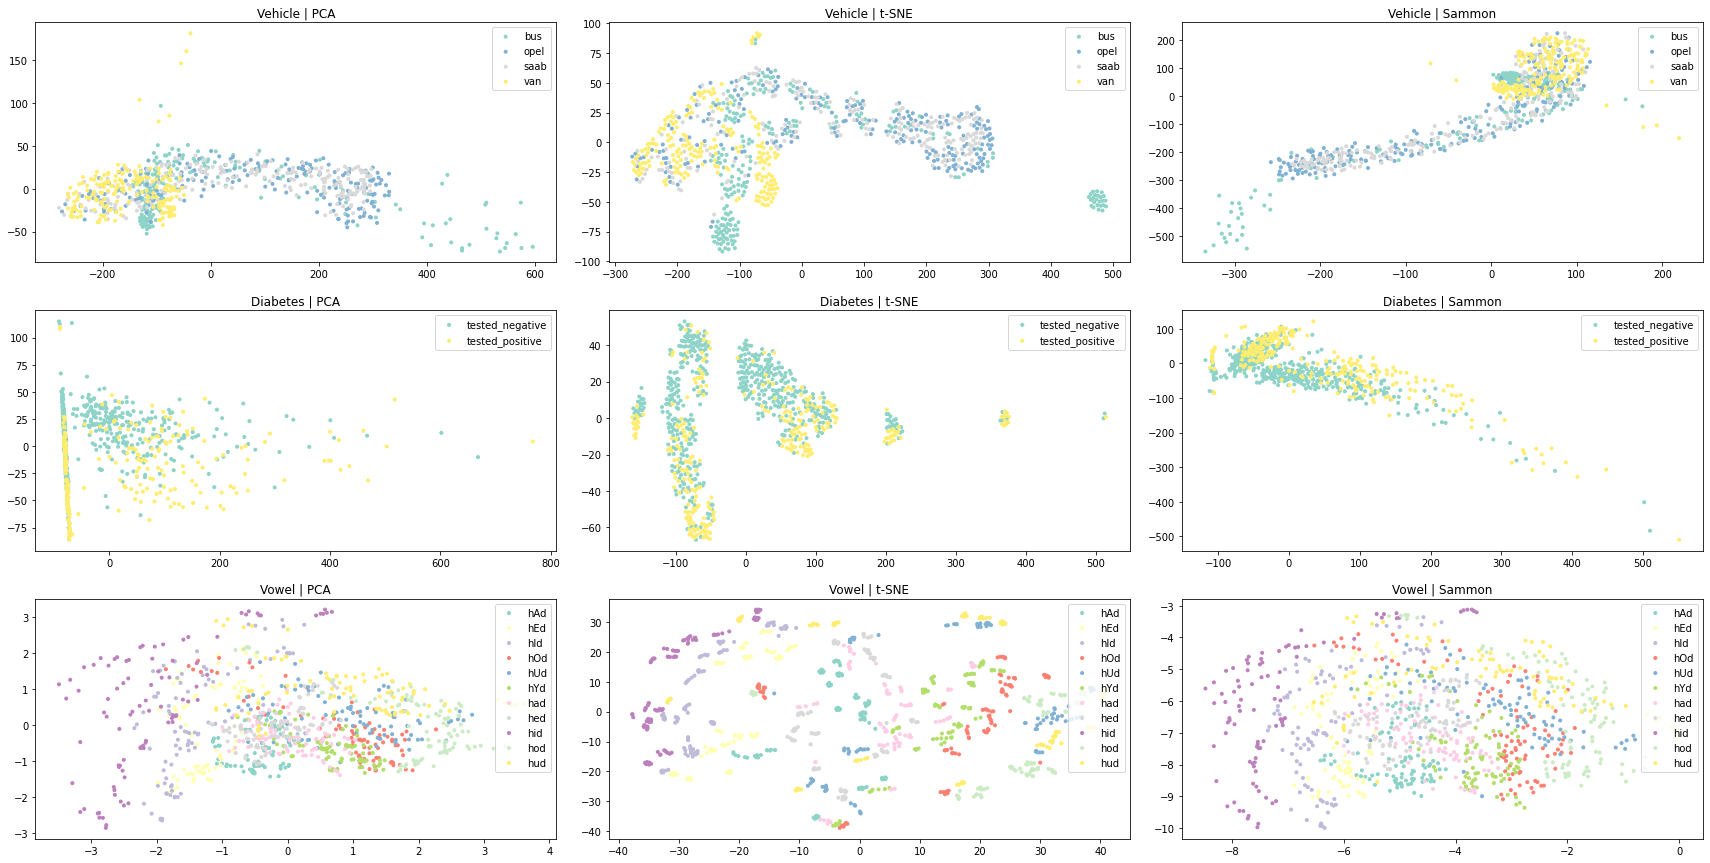

In [56]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import warnings
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from scipy.io import arff
warnings.filterwarnings("ignore") # Used to ignore warning prints from sklearn about upcoming changes to t-SNE

def load_data(file_path, x_lower, x_upper, y_pos):
    data = np.array(arff.loadarff(file_path)[0].tolist())
    X, classes = np.array(data[:, x_lower:x_upper], dtype=np.float64), np.array(data[:, y_pos], dtype=str)
    labels, y = np.unique(classes, return_inverse=True)
    return (X, y, labels)

def plot(X_pca, X_tsne, X_sammon, y, plt_i, labels, title):
    min_y, max_y = min(y), max(y)
    norm = Normalize(vmin=min_y, vmax=max_y)
    cmap = get_cmap("Set3")
    for r, X in enumerate([[X_pca, "PCA"], [X_tsne, "t-SNE"], [X_sammon, "Sammon"]]):
        plt.subplot(3, 3, plt_i + r)
        plt.title(f"{title} | {X[1]}")
        for i, l in enumerate(labels):
            plt.scatter(X[0][y==i, 0], X[0][y==i, 1], c=cmap(norm(y[y==i])), label=l, marker=".")
        plt.legend()


X_v, y_v, labels_v    = load_data("data/vehicle.arff", 0, -1, -1)
X_d, y_d, labels_d    = load_data("data/diabetes.arff", 0, -1, -1)
X_vo, y_vo, labels_vo = load_data("data/vowel.arff", 2, -1, -1)


Y_v_p = PCA(n_components=2).fit_transform(X_v)
Y_v_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_v)
Y_v_s = sammon(X_v, max_iter=200, epsilon=0.005, alpha=1, verbose=True)

Y_d_p = PCA(n_components=2).fit_transform(X_d)
Y_d_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_d)
Y_d_s = sammon(X_d, max_iter=200, epsilon=0.013, alpha=1, verbose=True)

Y_vo_p = PCA(n_components=2).fit_transform(X_vo)
Y_vo_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_vo)
Y_vo_s = sammon(X_vo, max_iter=200, epsilon=0.065, alpha=0.9, verbose=True)


plt.figure(figsize=(24, 12))
plot(Y_v_p, Y_v_t, Y_v_s, y_v, 1, labels_v, "Vehicle")
plot(Y_d_p, Y_d_t, Y_d_s, y_d, 4, labels_d, "Diabetes")
plot(Y_vo_p, Y_vo_t, Y_vo_s, y_vo, 7, labels_vo, "Vowel")
plt.subplots_adjust(left=0.025, bottom=0.025, right=0.99, top=0.97, wspace=0.1, hspace=0.2)
plt.show()

### 3.1: 1)
For the vehicle dataset I would say t-SNE performed the best.  
Again, t-SNE seems to perform better for the diabetes dataset. Sammon performs okay, zooming in shows that the overlapping is not as bad as it seems.  
Looking at the vowel dataset, PCA and Sammon is pretty similar. Sammon is a bit more separated though, but I would say that t-SNE performs the best once again.

### 3.1: 2)
In the vehicle dataset the classes should be separated by the sillhouettes of four different vehicles. t-SNE manages to separate busses and vans pretty well, while the opels and saabs gets mixed up. Same goes for sammon, which shows that it's hard to distinguish between those classes.   

There are only two classes in the diabetes dataset, tested positive and tested negative. t-SNE seems to manage to do some kind of grouping of the classes, but there are still a lot of points that are mixed, which indicates that there are a lot of similarities between the people that tested positive and those that tested negative.

The vowels dataset should be separated into 11 different classes and we can see that PCA and Sammon are having some trouble doing this. It gets a bit messy in the middle. However, we can still see that the classes that are more similar are close to each other, like hId and hid. This is made a bit more clear with t-SNE, but it still shows that some vowels are alike and especially since multiple peoples voices have been used in the dataset.   

Overall, it seems to be three kinda hard datasets to visualize for any of the three methods, and it shows that there are a lot of similarities between the different classes. PCA just doesn't feel suited for this kind of data.

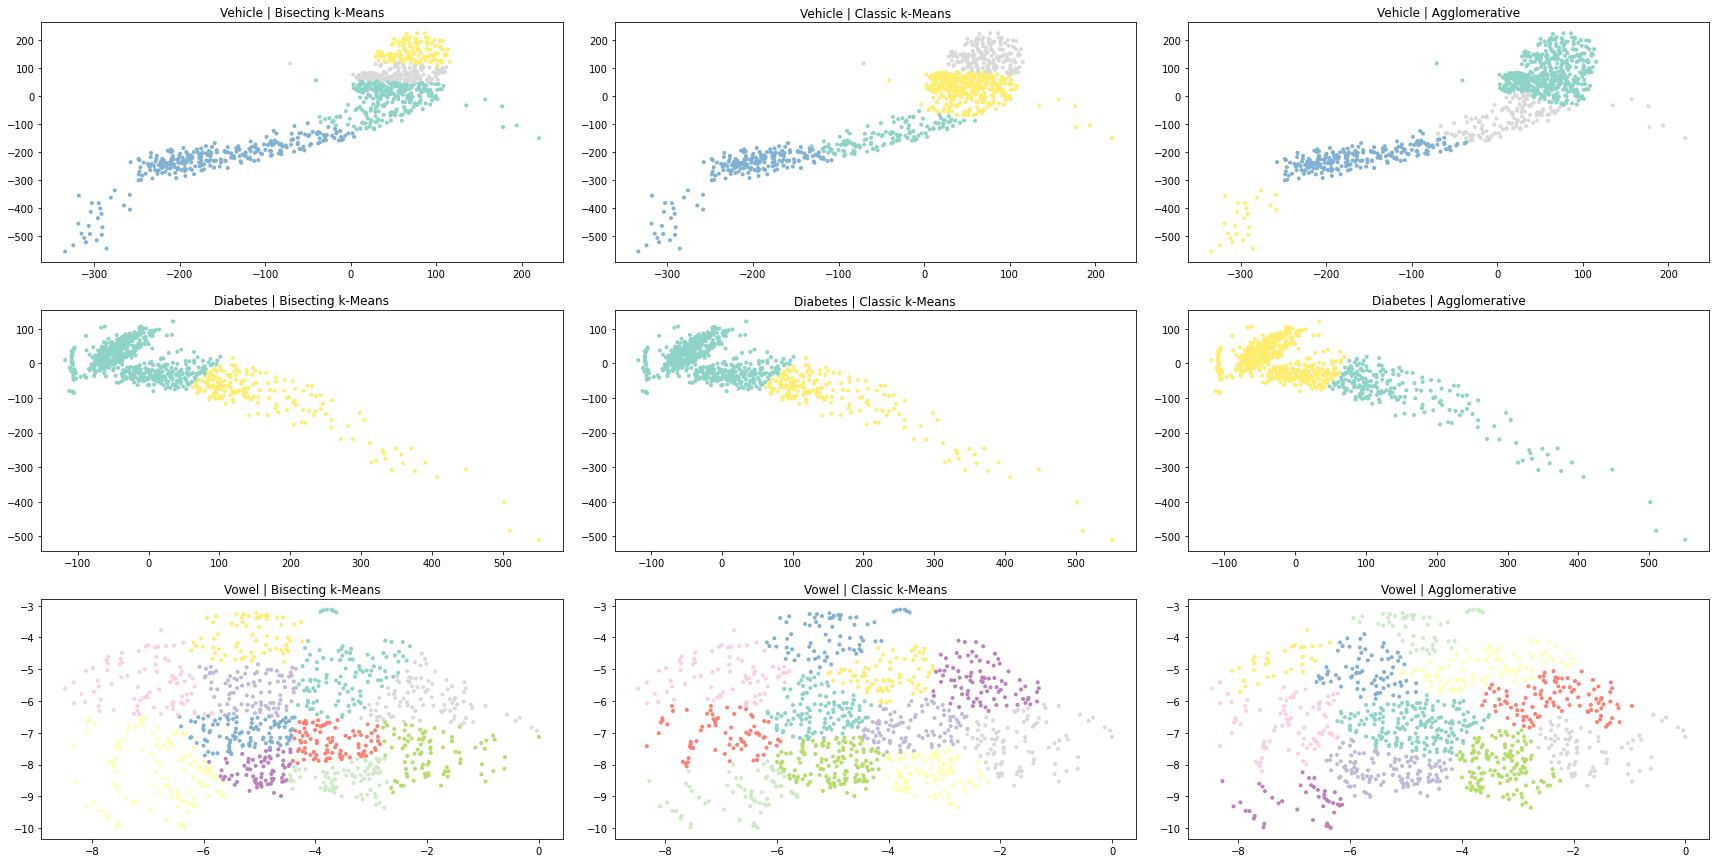

In [57]:
from sklearn.cluster import k_means
from sklearn.cluster import AgglomerativeClustering

def plot_clustering(X_vehicle, X_diabetes, X_vowel, y_vehicle, y_diabetes, y_vowel, labels_vehicle, labels_diabetes, labels_vowel):
    iters = 10
    labels = [labels_vehicle, labels_diabetes, labels_vowel]
    y = [y_vehicle, y_diabetes, y_vowel]
    for r, X in enumerate([X_vehicle, X_diabetes, X_vowel]):
        bkm = bkmeans(X, len(labels[r]), iters)
        km = k_means(X, len(labels[r]), n_init=iters)[1]
        ac = AgglomerativeClustering(len(labels[r])).fit_predict(X)
        for c, Y in enumerate([bkm, km, ac]):
            norm = Normalize(vmin=0, vmax=max(y[r]))
            cmap = get_cmap("Set3")
            plt.subplot(3, 3, [1, 4, 7][r] + c)
            plt.title(f'{["Vehicle", "Diabetes", "Vowel"][r]} | {["Bisecting k-Means", "Classic k-Means", "Agglomerative"][c]}')
            plt.scatter(X[:, 0], X[:, 1], c=cmap(norm(Y)), marker=".")

plt.figure(figsize=(24, 12))
plot_clustering(Y_v_s, Y_d_s, Y_vo_s, y_v, y_d, y_vo, labels_v, labels_d, labels_vo)
plt.subplots_adjust(left=0.025, bottom=0.025, right=0.99, top=0.97, wspace=0.1, hspace=0.2)
plt.show()

### 3.2
For the vehicle dataset I would say the Bisecting k-Means performs the best. It manages to make a cluster (yellow) where there are a lot of green points in the original plot. Ignoring the original labels and colors as if we didn't have the answer, I think the Classic k-Means clustering performs the best, just looking at the positions of the points.  

Looking at the diabetes dataset, it's hard data to separate for these clustering algorithms. Bisecting and Classic looks identical and I would say that the small difference between Agglomerative and the other two barley gives the advantage to the hierarchical method. However, there is such a small difference that you can't really tell which is the best just by looking at it. 

For the last dataset, vowels, it feels like a crapshoot, hard to say which performs the best. If I have to choose, there is something about the bisecting k-Means that feels a bit better.